In [2]:
!pip3 install torch torchvision

    100% |████████████████████████████████| 2.0MB 1.5MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


**Import LIbraries**

In [0]:
# Import LIbraries

import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms

In [4]:
transform = transforms.Compose([transforms.Resize((28, 28)), # (1) 사이즈 재조정 28 * 28로
                                transforms.ToTensor(), # (2) 그걸 Tensor로 바꾼다 0~255 Float Tensor 0~1
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # 0.5 이걸 기준으로 정규화 시킨다
                                # [1] 뮤 mean = 0.5 (Width 0.5, Height 0.5), [2] 시그마 std = 0.5 (Width 0.5, Height 0.5)
                                # (0 - 0.5) / 0.5 = -1   +    (1-0.5) / 0.5 = 1
                               ])

# Download MNIST
training_dataset = datasets.MNIST(root = './data', train=True, download = True, transform = transform) # 훈련 데이터셋
training_dataset

Processing...
Done!


Dataset MNIST
    Number of datapoints: 60000
    Split: train
    Root Location: ./data
    Transforms (if any): Compose(
                             Resize(size=(28, 28), interpolation=PIL.Image.BILINEAR)
                             ToTensor()
                             Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                         )
    Target Transforms (if any): None

In [5]:
training_loader = torch.utils.data.DataLoader(training_dataset, batch_size = 100, shuffle = True) # 훈련
training_loader

In [6]:
validation_dataset = datasets.MNIST(root = './data', train=False, download = True, transform = transform) # 유효성 검증 데이터셋
validation_dataset

Dataset MNIST
    Number of datapoints: 10000
    Split: test
    Root Location: ./data
    Transforms (if any): Compose(
                             Resize(size=(28, 28), interpolation=PIL.Image.BILINEAR)
                             ToTensor()
                             Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                         )
    Target Transforms (if any): None

In [7]:
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = 100, shuffle = False) # 유효성 검증
validation_loader

**Numpy Image Conversion Function**

In [0]:
def im_convert(tensor):
  image = tensor.clone().detach().numpy()
  #  First dimension now represents color channel
  #  Second and Third Dimensions represent the Width and the Height of the image and pixels
  image = image.transpose(1, 2, 0) 
  # (28, 28, 1)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  # applying the clip function to a minimum value of 0 and a maximum value of 1
  return image

**Plotting Image Data**

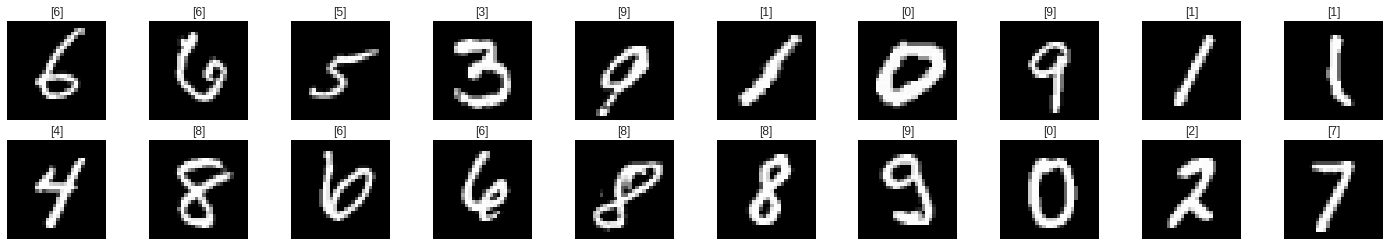

In [9]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 4)) # 사이즈는 세로 25, 가로 4
 
for idx in np.arange(20): # 20개 보여달라
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[]) # 세로 2, 가로 10 형식으로 보여달라. 20개를
  plt.imshow(im_convert(images[idx])) # 20개 보여줘
  ax.set_title([labels[idx].item()]) # 제목과 함께.

**Model Class Constructor**

In [0]:
# 분류하기
# Neural Network 활용

class Classifier(nn.Module):
  
  def __init__(self, D_in, H1, H2, D_out):
      super().__init__()
      self.linear1 = nn.Linear(D_in, H1) # Input, Hidden Layer 1
      self.linear2 = nn.Linear(H1, H2) # Hidden Layer 1, Hidden Layer 2
      self.linear3 = nn.Linear(H2, D_out) # Hidden Layer 2, Output
      
  def forward(self, x):
      x = F.relu(self.linear1(x))
      x = F.relu(self.linear2(x))
      x = self.linear3(x)
      return x

**Declaring Classifier**

In [11]:
model = Classifier(784, 125, 65, 10)
# 점차 줄이기
# 784(28 * 28) -> 125 -> 65 -> 마지막 10
model

Classifier(
  (linear1): Linear(in_features=784, out_features=125, bias=True)
  (linear2): Linear(in_features=125, out_features=65, bias=True)
  (linear3): Linear(in_features=65, out_features=10, bias=True)
)

**Loss and Optimizer**

In [0]:
criterion = nn.CrossEntropyLoss() # Cross Entropy를 활용한 Loss 측정
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001) # 활성화빈도 0.001

**Training Process**

In [0]:
epochs = 12 # 12번 돌린다

# History들은 []로 다 처리한다.
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

In [17]:
for e in range(epochs):
  
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0
  
  for inputs, labels in training_loader:
    inputs = inputs.view(inputs.shape[0], -1)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
    optimizer.zero_grad() # Zero_Grad 함수를 활용한 최적화
    loss.backward() 
    optimizer.step()
    
    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
 
  else:
    with torch.no_grad():
      for val_inputs, val_labels in validation_loader:
        val_inputs = val_inputs.view(val_inputs.shape[0], -1)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)
        
        _, val_preds = torch.max(val_outputs, 1)
        val_running_loss += val_loss.item()
        val_running_corrects += torch.sum(val_preds == val_labels.data)
      
    epoch_loss = running_loss/len(training_loader)
    epoch_acc = running_corrects.float() / len(training_loader)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)
    
    val_epoch_loss = val_running_loss/len(validation_loader)
    val_epoch_acc = val_running_corrects.float() / len(validation_loader)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)
    print('epoch :', (e+1)) # for e in range(epochs)
    
    print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
    # epoch_loss = running_loss/len(training_loader)
    # epoch_acc = running_corrects.float() / len(training_loader)
    
    print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))
    # val_epoch_loss = val_running_loss/len(validation_loader)
    # val_epoch_acc = val_running_corrects.float() / len(validation_loader)

epoch : 1
training loss: 0.1505, acc 95.4767 
validation loss: 0.1250, validation acc 96.0900 
epoch : 2
training loss: 0.1164, acc 96.5033 
validation loss: 0.1144, validation acc 96.5400 
epoch : 3
training loss: 0.0950, acc 97.0100 
validation loss: 0.1251, validation acc 96.1900 
epoch : 4
training loss: 0.0823, acc 97.4700 
validation loss: 0.0872, validation acc 97.2800 
epoch : 5
training loss: 0.0759, acc 97.6333 
validation loss: 0.0866, validation acc 97.2500 
epoch : 6
training loss: 0.0651, acc 97.9000 
validation loss: 0.0909, validation acc 97.3300 
epoch : 7
training loss: 0.0608, acc 98.0350 
validation loss: 0.0903, validation acc 97.3200 
epoch : 8
training loss: 0.0516, acc 98.3450 
validation loss: 0.0971, validation acc 97.2700 
epoch : 9
training loss: 0.0492, acc 98.3800 
validation loss: 0.0848, validation acc 97.6100 
epoch : 10
training loss: 0.0415, acc 98.6117 
validation loss: 0.0925, validation acc 97.4500 
epoch : 11
training loss: 0.0413, acc 98.5783 
va

**Plotting Training Loss**

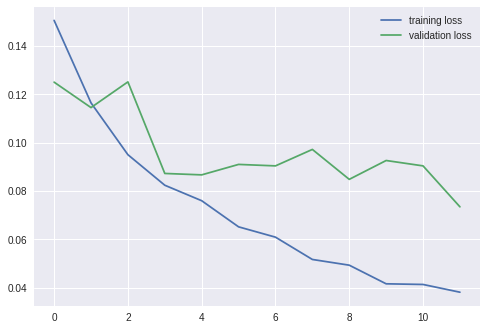

In [18]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

**Plotting Accuracy**

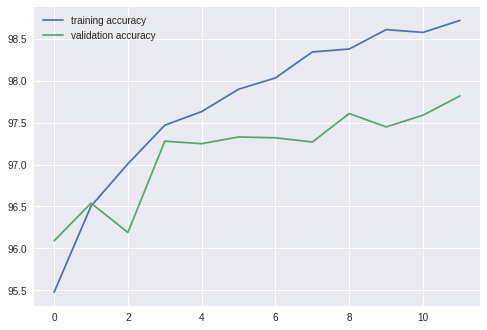

In [19]:
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()

In [20]:
!pip3 install pillow==4.0.0

    100% |████████████████████████████████| 5.6MB 5.2MB/s 
torchvision 0.2.1 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
  Found existing installation: Pillow 5.4.1
    Uninstalling Pillow-5.4.1:
      Successfully uninstalled Pillow-5.4.1


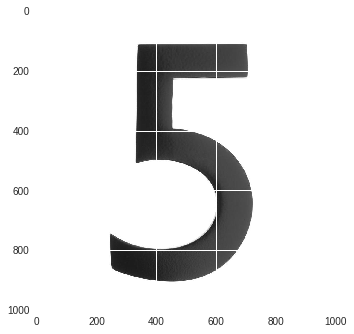

In [21]:
import requests
from PIL import Image
 
url = 'https://images.homedepot-static.com/productImages/007164ea-d47e-4f66-8d8c-fd9f621984a2/svn/architectural-mailboxes-house-letters-numbers-3585b-5-64_1000.jpg'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)

In [22]:
img = PIL.ImageOps.invert(img)
img = img.convert('1')
img = transform(img) 
plt.imshow(im_convert(img))

NameError: ignored

In [23]:
img = img.view(img.shape[0], -1)
output = model(img)
_, pred = torch.max(output, 1)
print(pred.item())


AttributeError: ignored

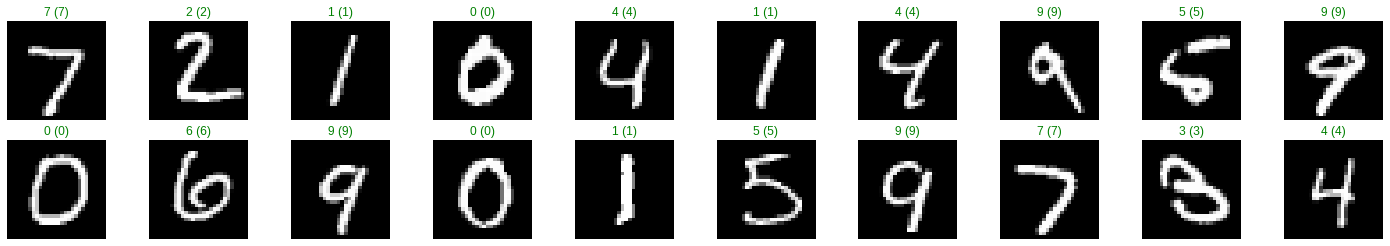

In [24]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()
images_ = images.view(images.shape[0], -1)
output = model(images_)
_, preds = torch.max(output, 1)
 
fig = plt.figure(figsize=(25, 4))
 
for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())), color=("green" if preds[idx]==labels[idx] else "red"))
